In [9]:
# Download AFAD dataset
import os
import tarfile

dataset_tar = 'afad.tar.xz'
dataset_folder = 'AFAD-Full'

if dataset_folder not in os.listdir():
    !git clone https://github.com/John-niu-07/tarball.git
    !cat tarball/AFAD-Full.tar.xz* > {dataset_tar}
    !rm -rfv tarball
    !tar -xf {dataset_tar}
    !rm {dataset_tar}


# Dataset labelling
from tqdm import tqdm

afad_filenames = []
afad_ages = []

for age in tqdm(os.listdir(dataset_folder)):
    if (age == 'AFAD-Full.txt') or (age == 'README.md'): # Ignore txt and README file
        continue
    
    sub_folders = os.listdir(
        os.path.join(
            dataset_folder, age
        )
    )
    
    for sf in sub_folders:
        cur_folder = os.path.join(
            dataset_folder, age, sf
        )
        for file in os.listdir(cur_folder):
            afad_filenames.append(
                os.path.join(
                    cur_folder, file
                )
            )
            afad_ages.append(int(age))


# Create pandas dataframe
import pandas as pd

afad_dataframe = pd.DataFrame(
    {
    'image_path': afad_filenames,
    'age': afad_ages
    }
)

def convert_label(age):
    return 1 if int(age) >= 18 else 0

afad_dataframe['label'] = afad_dataframe['age'].apply(convert_label)

print(afad_dataframe['label'].value_counts())
afad_dataframe

100%|██████████| 63/63 [00:00<00:00, 204.77it/s]


label
1    159359
0      6156
Name: count, dtype: int64


,image_path,age,label
0,AFAD-Full/69/111/858319-0.jpg,69,1
1,AFAD-Full/69/111/858687-0.jpg,69,1
2,AFAD-Full/69/111/859750-0.jpg,69,1
3,AFAD-Full/69/111/858859-0.jpg,69,1
4,AFAD-Full/69/111/858910-0.jpg,69,1
...,...,...,...
165510,AFAD-Full/19/112/30783-0.jpg,19,1
165511,AFAD-Full/19/112/245249-1.jpg,19,1
165512,AFAD-Full/19/112/280452-0.jpg,19,1
165513,AFAD-Full/19/112/112370-0.jpg,19,1


In [11]:
# Download UTKFace dataset (add the dataset manually through kaggle)
utkface_folder = "/kaggle/input/utkface-new"
selected_subset = 'crop_part1'

utkface_path = os.path.join(utkface_folder, selected_subset)

utk_filenames = []
utk_ages = []
for utkfile in os.listdir(utkface_path):
    file_info = utkfile[:-13] # Remove extension (.jpg.chip.jpg)
    file_info = file_info.split('_')
    race_id = file_info[2]
    if int(race_id) == 2: # race id for Asian
        utk_filenames.append(
            os.path.join(
                utkface_path, utkfile
            )            
        )
        utk_ages.append(
            int(file_info[0])
        )
        
utkface_dataframe = pd.DataFrame(
    {
    'image_path': utk_filenames,
    'age': utk_ages
    }
)

utkface_dataframe['label'] = utkface_dataframe['age'].apply(convert_label)

print(utkface_dataframe['label'].value_counts())
utkface_dataframe

label
0    978
1    575
Name: count, dtype: int64


,image_path,age,label
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26,1
1,/kaggle/input/utkface-new/crop_part1/26_1_2_20...,26,1
2,/kaggle/input/utkface-new/crop_part1/90_0_2_20...,90,1
3,/kaggle/input/utkface-new/crop_part1/1_0_2_201...,1,0
4,/kaggle/input/utkface-new/crop_part1/1_1_2_201...,1,0
...,...,...,...
1548,/kaggle/input/utkface-new/crop_part1/1_0_2_201...,1,0
1549,/kaggle/input/utkface-new/crop_part1/57_1_2_20...,57,1
1550,/kaggle/input/utkface-new/crop_part1/38_1_2_20...,38,1
1551,/kaggle/input/utkface-new/crop_part1/3_0_2_201...,3,0


label
1    159359
0      6156
Name: count, dtype: int64


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

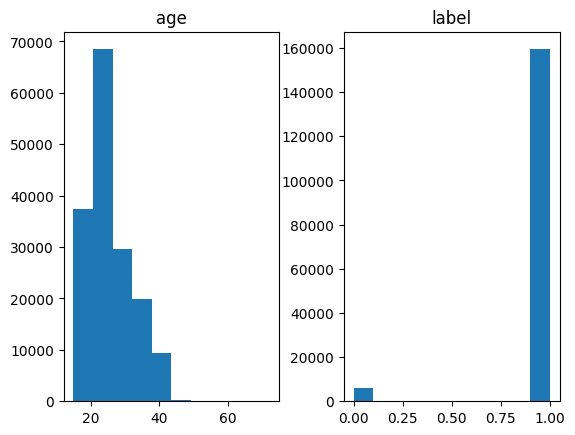

In [9]:
# Show image samples


label
0    6156
1    6156
Name: count, dtype: int64


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

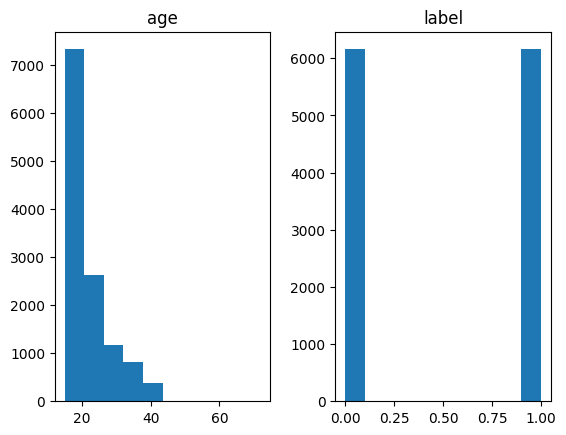

In [10]:
# Undersampling
total_per_label = dataframe['label'].value_counts().get(0)

undersampled_dataframe = dataframe.groupby('label').sample(n=total_per_label)

print(undersampled_dataframe['label'].value_counts())
undersampled_dataframe.hist(grid=False)

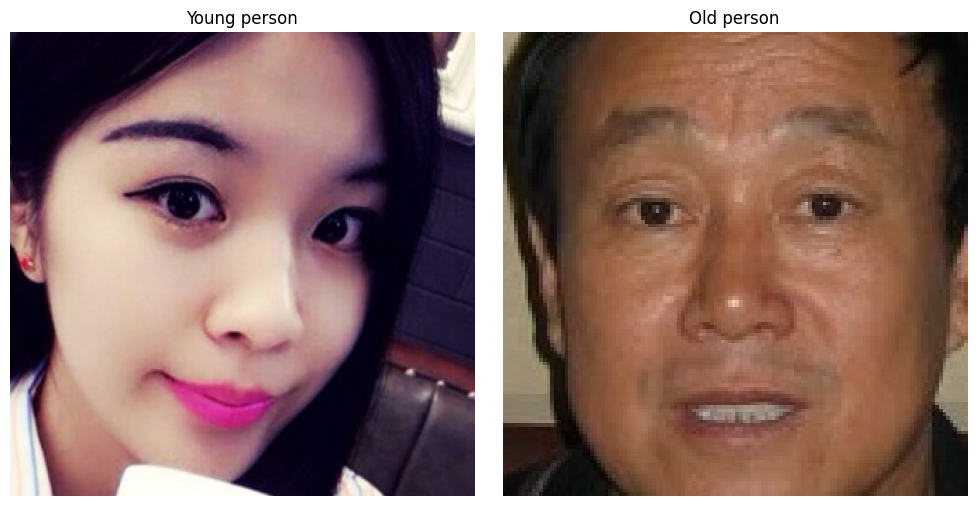

In [11]:
# Display sample image
import matplotlib.pyplot as plt
from PIL import Image

young_sample = undersampled_dataframe[undersampled_dataframe['age'] < 17].iloc[0]
old_sample = undersampled_dataframe[undersampled_dataframe['age'] > 50].iloc[0]

img_young = Image.open(young_sample.image_path)
img_old = Image.open(old_sample.image_path)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display first image
axes[0].imshow(img_young)
axes[0].axis("off")  # Hide axes
axes[0].set_title("Young person")

# Display second image
axes[1].imshow(img_old)
axes[1].axis("off")
axes[1].set_title("Old person")

# Adjust layout and show images
plt.tight_layout()
plt.show()

In [12]:
# remove 'age' column and reset index
undersampled_dataframe.drop(columns=['age'], inplace=True)
undersampled_dataframe.reset_index(drop=True, inplace=True)

In [13]:
# Create a PyTorch data loader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Create a custom pytorch dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, image_size=380):
        """
        Args:
            dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transforms.Compose(
            [transforms.Resize((image_size, image_size)),
            transforms.ToTensor()]
        )  

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch a sample (image and label) from the dataset."""
        img_name = self.dataframe.iloc[idx]['image_path']  # image path column
        label = self.dataframe.iloc[idx]['label']  # label column

        # Open the image
        image = Image.open(img_name).convert("RGB")  # Convert to RGB

        # Transform the image
        image = self.transform(image)

        return image, label


train_df, test_df = train_test_split(undersampled_dataframe, test_size=0.1)

train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True)

In [14]:
# Check total training and testing dataset
print(f"Total samples for model training = {len(train_dataset)}")
print(f"Total samples for model evaluation = {len(test_dataset)}")

Total samples for model training = 11080
Total samples for model evaluation = 1232


In [15]:
# Define model and hyperparameters
import torch.nn as nn
from torchvision import models
import torch.optim as optim


class EfficientNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(EfficientNetBinaryClassifier, self).__init__()
        self.model = models.efficientnet_v2_s(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)  # Change output to 1 neuron (binary classification)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNetBinaryClassifier()


criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 93.1MB/s]


In [16]:
# Model training loop
import torch

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
verbose_steps = 200


step = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Pass the data to specified device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print running loss every verbose steps
        running_loss += loss.item()
        step += 1
        if (step + 1) % verbose_steps == 0:
            print(f"Current loss: {loss.item()}")
        
        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Current loss: 0.5069418549537659
Current loss: 0.6993423700332642
Current loss: 0.6781424283981323
Current loss: 0.457573264837265
Current loss: 0.5034691691398621
Current loss: 0.5898056030273438
Epoch [1/10], Loss: 0.6112, Accuracy: 66.93%
Current loss: 0.5551671385765076
Current loss: 0.5949097871780396
Current loss: 0.44092798233032227
Current loss: 0.44877997040748596
Current loss: 0.6954972743988037
Current loss: 0.42669183015823364
Current loss: 0.4010277986526489
Epoch [2/10], Loss: 0.5322, Accuracy: 73.29%
Current loss: 0.23272459208965302
Current loss: 0.28901222348213196
Current loss: 0.5906710028648376
Current loss: 0.17851367592811584
Current loss: 0.30082136392593384
Current loss: 0.3506074547767639
Current loss: 0.6116408109664917
Epoch [3/10], Loss: 0.4360, Accuracy: 79.70%
Current loss: 0.1090410053730011
Current loss: 0.154783234000206
Current loss: 0.6062512397766113
Current loss: 0.4688340723514557
Current loss: 0.06256787478923798
Current loss: 0.16724532842636108
